### Plotting yes or no (computationally expensive):

In [ ]:
plottting = False
plotting_testing = True

# References:

*   https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f
*   https://developers.arcgis.com/python/samples/openstreetmap-exploration/



# Connect to drive folder

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Install libraries

In [ ]:
%%capture
!pip install osmnx polars pyshp geofeather
#pyshp --> Python Shapefile Library (PyShp)

In [ ]:
# Data management
import pandas as pd
import datetime
import numpy as np
import polars as pl
import zipfile, io
import os
import numpy as np
import re
import functools
import urllib
import shutil
import warnings
from collections import Counter
import progressbar
from time import sleep
warnings.simplefilter("ignore")


# Geospatial libraries
import osmnx as ox
import shapefile as shp
import geopandas as gpd
import geofeather


# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the data

In [ ]:
os.chdir("/content/gdrive")
os.getcwd()

'/content/gdrive'

In [ ]:
def find_project_path(fold):
  for fold, subfold, file in os.walk(fold):
    x = re.search('Lab Smart Cities$', fold)
    if x != None:   # os.walk() returns a generator object that yields a 3-tuple (dirpath, dirnames, filenames) for each directory in the directory tree
      return fold

project_path = find_project_path(os.getcwd())
project_path

'/content/gdrive/MyDrive/Colab Notebooks/Lab Smart Cities'

In [ ]:
# specify folder drive
zip_list = []
fold = os.path.join(project_path, 'DATI')   #If any component is an absolute path, all previous path components will be discarded, like "/content" in our case, which is written 2 times

# extact all zip folder
for file in os.listdir(fold):
    if file.endswith(".zip"):
      zip_list.append(file)
print('Zip files: ', zip_list)

Zip files:  ['MILANO.zip', 'ImmDegrado.zip', 'Orografia.zip', 'Temperature.zip', 'Viabilità.zip', 'Idrografia.zip', 'Antropizzazione.zip']


In [ ]:
#Folder for storing the file formats from the .zips, according to their completeness
zip_complete_path = os.path.join(fold, f'COMPLETE')
zip_uncomplete_path = os.path.join(fold, f'UNCOMPLETE')

print(zip_complete_path, f'\n{zip_uncomplete_path}')  #To create an f-string, prefix the string with the letter “ f ”. The string itself can be formatted in much the same way that you would with str.format(). F-strings provide a concise and convenient way to embed python expressions inside string literals for formatting

if not os.path.exists(zip_complete_path):
  os.mkdir(zip_complete_path)
if not os.path.exists(zip_uncomplete_path):
  os.mkdir(zip_uncomplete_path)
else:
  print('\n\nFolders already exist')

/content/gdrive/MyDrive/Colab Notebooks/Lab Smart Cities/DATI/COMPLETE 
/content/gdrive/MyDrive/Colab Notebooks/Lab Smart Cities/DATI/UNCOMPLETE


Folders already exist


In [ ]:
 # opening each zip file in READ mode
i = 0

for file_name in zip_list:     #zip_list names like "ImmDegrado.zip"
  i += 1
  print(i)
  print(file_name)
  full_file_name = file_name.replace('.zip', '')      #names like "ImmDegrado"
  with zipfile.ZipFile(os.path.join(fold, file_name), 'r') as zip:   #fold is "/content/gdrive/MyDrive/Colab Notebooks/Lab Smart Cities/DATI"

    listOfFileNames = zip.namelist()     #list all files in the zip   .shp,.dbt etc.
    names2 = [re.sub(r'\.(?!gpkg)\w+', '', fileName) for fileName in listOfFileNames]   #list of files names without the extension .shp,.dbt etc. but maintaing the .gpkg  A(?!B) | Negative lookahead assertion. This matches the expression A only if it is not followed by B

    # count name occurrences
    counts2 = Counter(names2)     #dictionary counting for each file with equals name in the list, the number of occurencies

    # Split files name with less extensions (sappiamo che ciascuno deve avere 4 estensioni (dbf, shp, shx, prj))
    complete_files = [name for name, val in counts2.items() if ((val >= 4) or (name.endswith('.gpkg')))]
    uncomplete_files = [name for name, val in counts2.items() if (val < 4)]
    print(f'{full_file_name} Uncompleted files = ', len(uncomplete_files)/(len(uncomplete_files) + len(complete_files))*100, '%')
    print(complete_files)
    print(f'{full_file_name} Completed files = ', len(complete_files)/(len(uncomplete_files) + len(complete_files))*100, '%')


    # extract files in different folder
    zip_name = zip.filename.replace(f'{fold}/', '').replace('.zip', '')      #zip_name as like "ImmDegrado"

    # i file corretti vanno estratti in una cartella, gli altri vengono estratti in un'altra cartella
    for fileName in listOfFileNames:    #list with all format .shp,.dbt etc. inside the zip file in reading mode
      if (re.sub(r'\.(?!gpkg)\w+', '', fileName) in complete_files) and (not(os.path.exists(os.path.join(zip_complete_path, full_file_name, fileName)))): #and not os.path.join(zip_complete_path, full_file_name):    #if the zip name is in the list of complet file
        zip.extract(fileName, '{}/{}'.format(zip_complete_path, full_file_name))   #extract files .shp,.dbt etc.  in the subfolder COMPLETE and folder ""ImmDegr
        if fileName in os.path.join(zip_complete_path, fileName):
          print(f'\{fileName}', ' correctly extracted in the "COMPLETE" folder' )

      if re.sub(r'\.\w+', '', fileName) in uncomplete_files and (not(os.path.exists(os.path.join(zip_uncomplete_path, full_file_name, fileName)))): #and not os.path.join(zip_uncomplete_path, full_file_name):
        zip.extract(fileName, '{}/{}'.format(zip_uncomplete_path, full_file_name))

print('Done!')

1
MILANO.zip
MILANO Uncompleted files =  66.66666666666666 %
['base_dbt_per_pianificazione.gpkg', 'dbgt.gpkg']
MILANO Completed files =  33.33333333333333 %
2
ImmDegrado.zip
ImmDegrado Uncompleted files =  0.0 %
['Immobili_abbandonati_e_degradati_aree', 'Immobili_abbandonati_e_degradati_punti']
ImmDegrado Completed files =  100.0 %
3
Orografia.zip
Orografia Uncompleted files =  0.0 %
['A050303', 'A050304', 'A050393', 'L050101', 'L050103', 'L050302', 'LIM_050393', 'P050102']
Orografia Completed files =  100.0 %
4
Temperature.zip
Temperature Uncompleted files =  66.66666666666666 %
['avgLST_Milan_UrbanAtlas']
Temperature Completed files =  33.33333333333333 %
5
Viabilità.zip
Viabilità Uncompleted files =  0.0 %
['A010101', 'A010102', 'A010103', 'A010104', 'A010105', 'A010201', 'L010105', 'L010107', 'L010202', 'L010204', 'L010206', 'L010210', 'LIM_010102', 'LIM_010103', 'LIM_010104', 'LIM_010105', 'P010108', 'P010203', 'P010205', 'P010207']
Viabilità Completed files =  100.0 %
6
Idrogr

#Read shp files and make a feather copy (increase speed)

In [ ]:
#Function for convert .shp files or .gpkg files in Geofeather
def convert_to_Geofeather (directoryCompleteUnzippedFolders):
  for subfolds in os.listdir(directoryCompleteUnzippedFolders):
    if not os.path.exists(os.path.join(directoryCompleteUnzippedFolders, f'{subfolds}/Geofeather')):
      os.mkdir(os.path.join(directoryCompleteUnzippedFolders, f'{subfolds}/Geofeather'))


      Others_datasets = 0
      Others_datasets_failed_load = 0
      time = []

      i_subfolds = -1

      print(subfolds)

      sub = os.path.join(project_path, f'DATI/COMPLETE/{subfolds}')

      # create a progress bar
      #len of the bar proportional to the lenght of the subfolder of files
      bar_subfolds = progressbar.ProgressBar(maxval=len(os.listdir(sub))-1, #\
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
      bar_subfolds.start()

      os.chdir(os.path.join(project_path, f'DATI/COMPLETE/{subfolds}'))      #es. "/content/gdrive/MyDrive/Colab Notebooks/Lab Smart Cities/DATI/COMPLETE/ImmDegrado"

      for ext in os.listdir(os.getcwd()):
        i_subfolds += 1
        if ext.endswith('.shp'):
          # print(ext)
          ct = datetime.datetime.now()
          try:
            a = gpd.read_file(ext)          #read the .sho with geopandas
            Others_datasets += 1
            end_t = datetime.datetime.now()

            # convert geopandas to Geofeather (faster way)
            geofeather.to_geofeather(a, os.path.join(project_path, 'DATI/COMPLETE/{}/Geofeather/{}'.format(subfolds, ext.replace('.shp', ''))))   #take the .shp file and convert to geofeather inside the same subfolder (es. "ImmDegrado"), in another folder called Geofeather
          except:
            Others_datasets_failed_load += 1

          delta = (end_t - ct).total_seconds()
          if delta > 25:
            print('\\---------------------------------------------------------------------')
            print('Current time: ', ct)
            print('\nEnd operation: ', end_t)
            print('\nDelta = ', delta)
          time.append(delta)




        elif ext.endswith('.gpkg'):

          ct = datetime.datetime.now()
          try:
            a = gpd.read_file(ext)          #read the .sho with geopandas
            Others_datasets += 1
            end_t = datetime.datetime.now()

            # convert GPKG File to Geofeather (faster way)
            geofeather.to_geofeather(a, os.path.join(project_path, 'DATI/COMPLETE/{}/Geofeather/{}'.format(subfolds, ext.replace('.gpkg', ''))))   #take the .gpkg file and convert to geofeather inside the same subfolder (es. "Milano"), in another folder called Geofeather
          except:
            Others_datasets_failed_load += 1

          delta = (end_t - ct).total_seconds()
          if delta > 25:
            print('\\---------------------------------------------------------------------')
            print('Current time: ', ct)
            print('\nEnd operation: ', end_t)
            print('\nDelta = ', delta)
          time.append(delta)


      bar_subfolds.update(i_subfolds)
      sleep(0.1)
      bar_subfolds.finish()


      print('\n\nDatasets available = ', Others_datasets, '\nDatasets not available = ', Others_datasets_failed_load)
      print('\n\nAverage delta time = ', np.mean(time), '\nMax time = ', np.max(time), '    Min time = ', np.min(time))
      print('\nTotal time (minutes)= ', sum(time)/60)

    else:
      print('Script already executed')

In [ ]:
if os.getcwd() != os.path.join(project_path, 'DATI/COMPLETE'):
  os.chdir(os.path.join(project_path, 'DATI/COMPLETE'))
dirComplete = os.getcwd()
convert_to_Geofeather(dirComplete)


Script already executed
Script already executed
Script already executed
Script already executed
Script already executed
Script already executed
Script already executed


In [ ]:
def plot_dt(dt):
  j = 0

  #create a progress bar
  bar = progressbar.ProgressBar(maxval=1, \
  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()
  start = datetime.datetime.now()

  a = dt.geometry.plot(figsize=(5,5))

  j += 1
  end = datetime.datetime.now()
  delta = (end - start).total_seconds()
  bar.finish()

  print(f'\nTime occurred for plotting = {delta}s')

  return a

In [ ]:
datasets = {}

def get_geofeather_Files(subFolder_name):
  focus = subFolder_name
  if os.getcwd() != os.path.join(project_path, f'DATI/COMPLETE/{focus}/Geofeather'):
    os.chdir(os.path.join(project_path, f'DATI/COMPLETE/{focus}/Geofeather'))

  datasets[focus] = []

  for ext in os.listdir(os.getcwd()):
    try:
      datasets[focus].append(geofeather.from_geofeather(ext))   #get all files in the folder Geofeather, in order to print all of them
    except:
      continue
  return datasets[focus]   #return a list of file open in geofeather format


## Antropizzazione

[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 12.844789s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 9.920687s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 5.485641s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 0.359902s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 1.278479s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 7.443676s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 37.47092s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 0.290679s


[========================================================================] 100%
[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 23.010441s

Time occurred for plotting = 0.099441s


[========================================================================] 100%
[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 0.352958s

Time occurred for plotting = 0.133959s


[========================================================================] 100%
[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 1.122443s

Time occurred for plotting = 0.099267s


[========================================================================] 100%
[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 1.002944s

Time occurred for plotting = 0.120088s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 28.165271s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 2.423126s


[========================================================================] 100%
[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 9.265508s

Time occurred for plotting = 0.09673s


[========================================================================] 100%
[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 0.187369s

Time occurred for plotting = 0.132964s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 0.548939s


[========================================================================] 100%



Time occurred for plotting = 0.531915s


[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >]

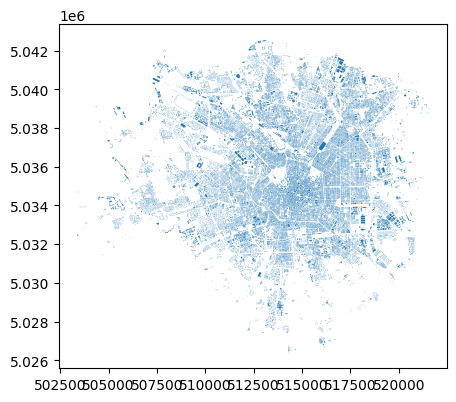

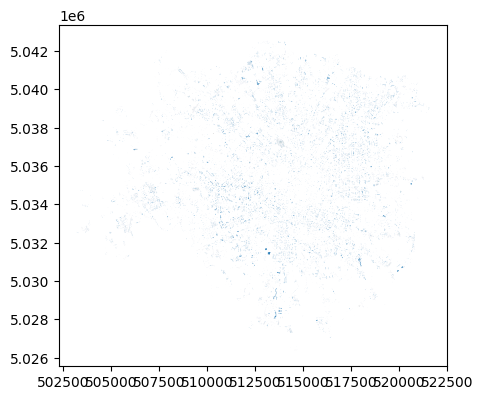

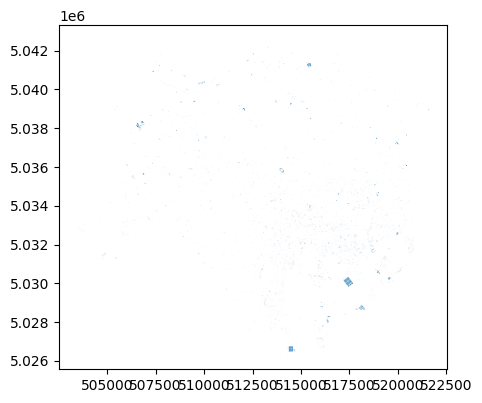

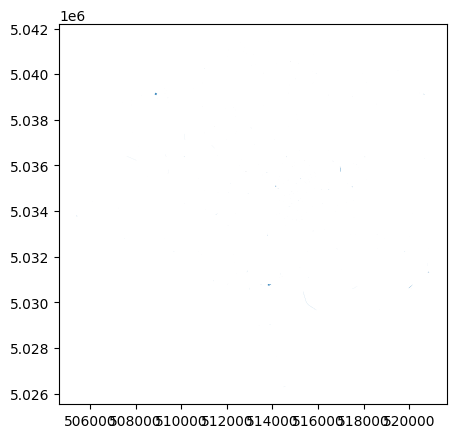

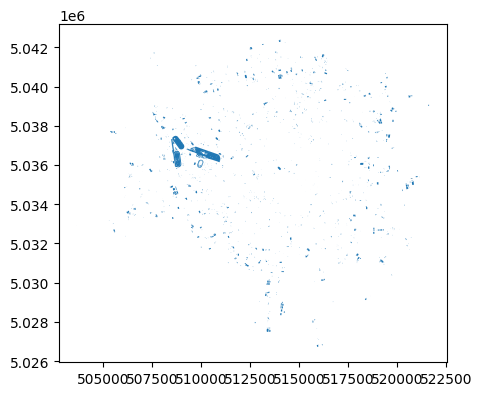

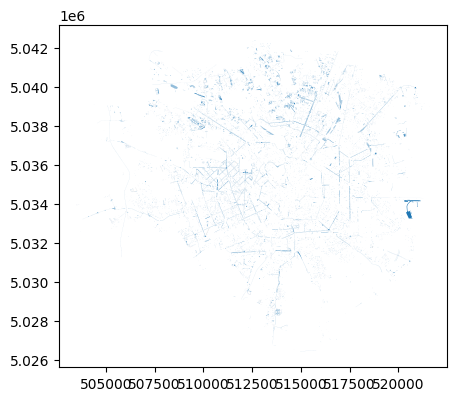

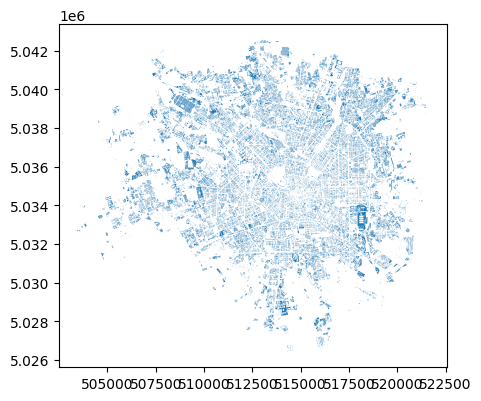

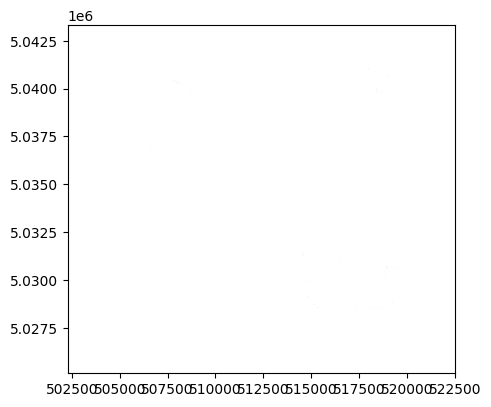

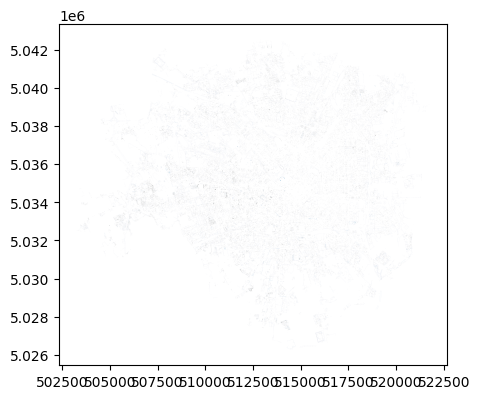

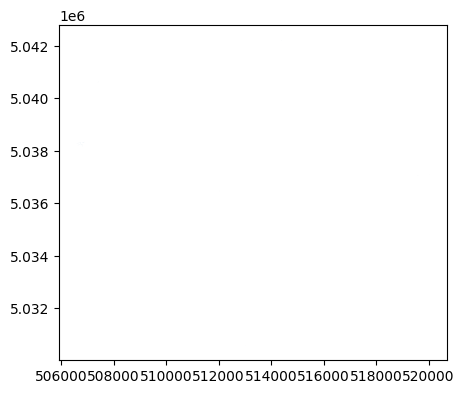

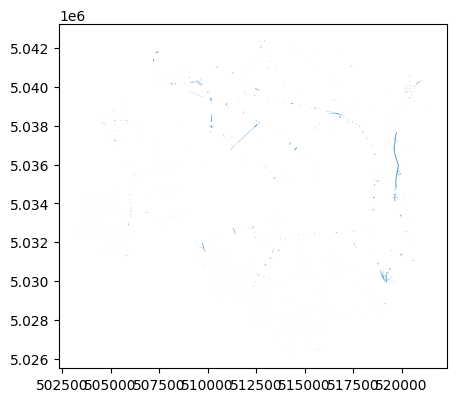

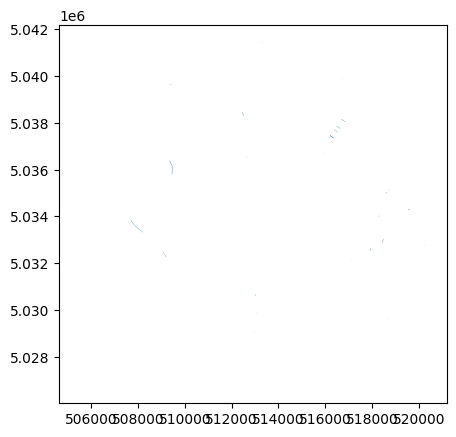

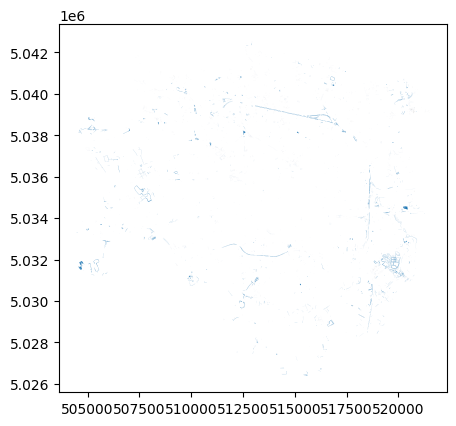

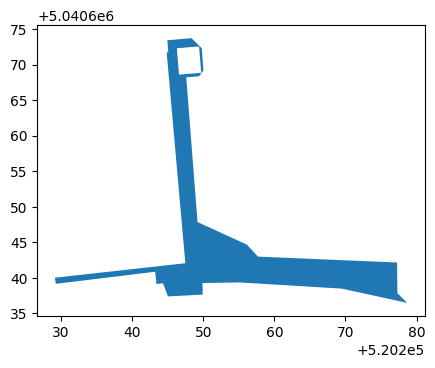

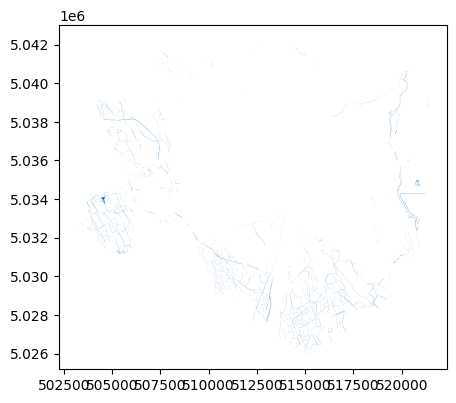

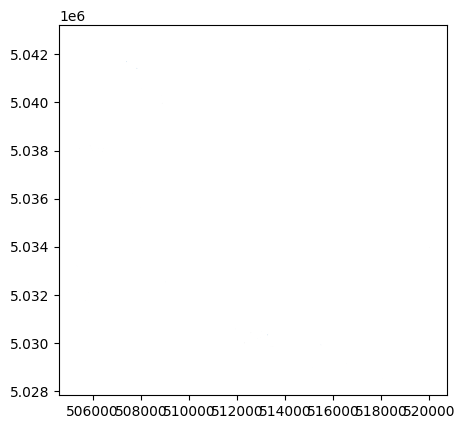

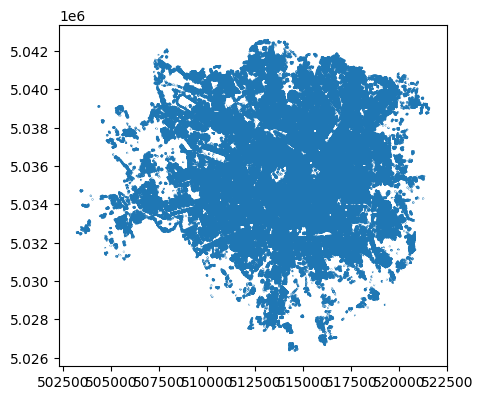

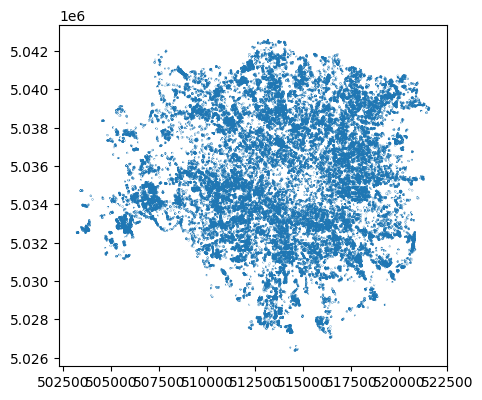

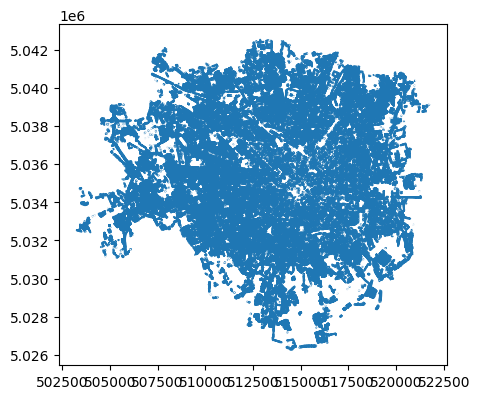

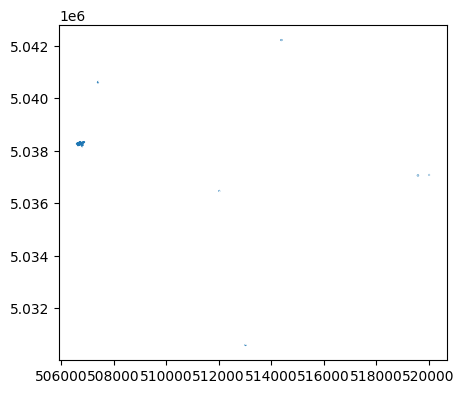

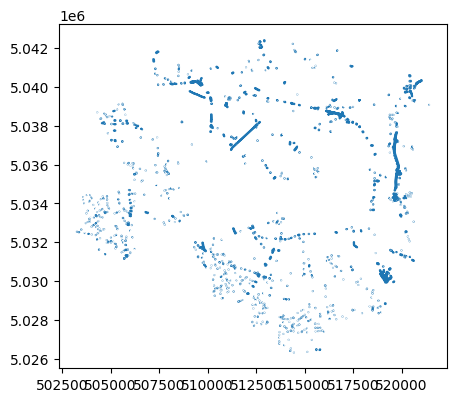

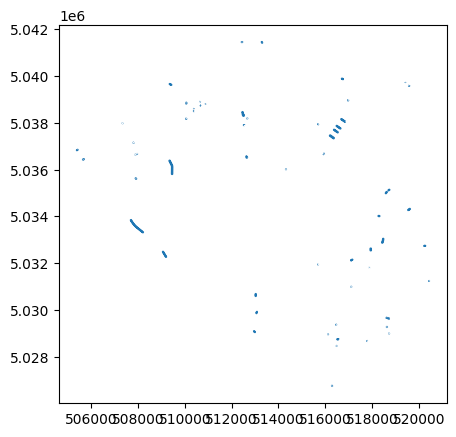

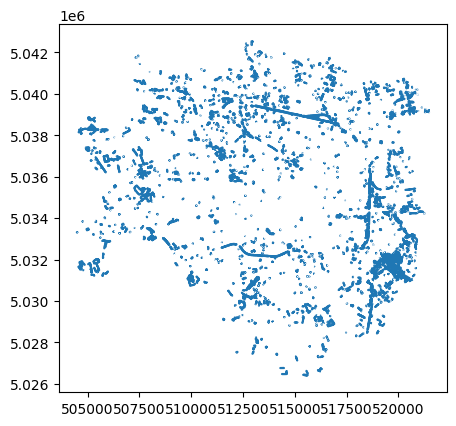

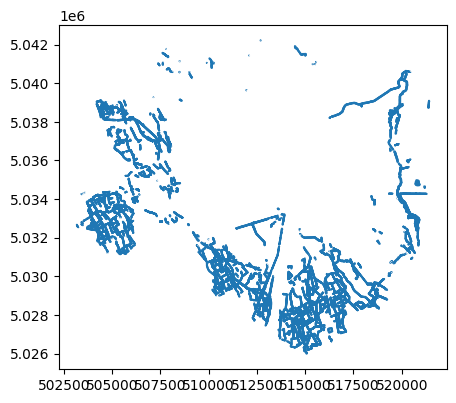

In [ ]:
if plottting:
  list(map(plot_dt, get_geofeather_Files("Antropizzazione")))

## ImmDegrado

[========================================================================] 100%
[========================================================================] 100%



Time occurred for plotting = 0.137856s

Time occurred for plotting = 0.139522s


[<Axes: >, <Axes: >]

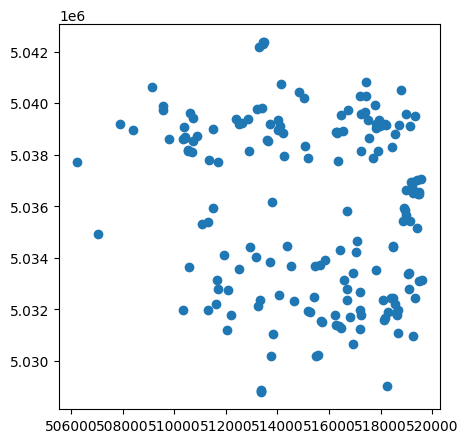

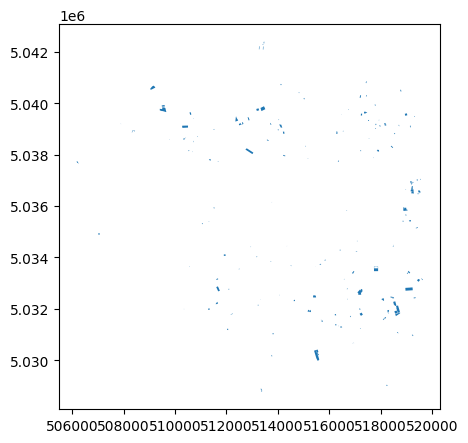

In [ ]:
if plottting:
  list(map(plot_dt, get_geofeather_Files("ImmDegrado")))

## Viabilità

[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 5.655807s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 13.146659s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 0.241865s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 0.90398s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 0.43439s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 2.300687s


[========================================================================] 100%
[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 7.903015s

Time occurred for plotting = 0.145982s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 3.529891s


[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 1.512805s


[========================================================================] 100%



Time occurred for plotting = 5.510267s


[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >]

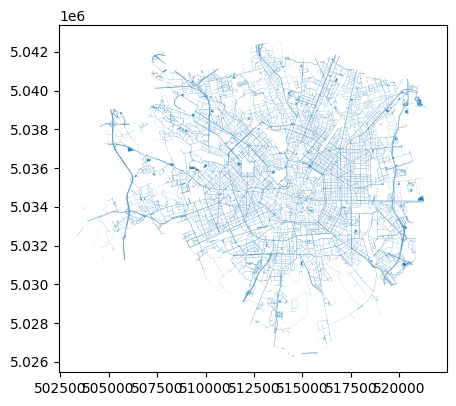

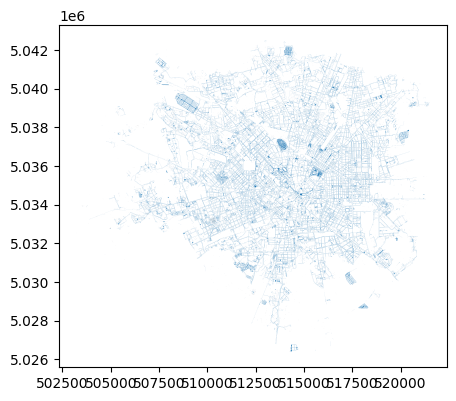

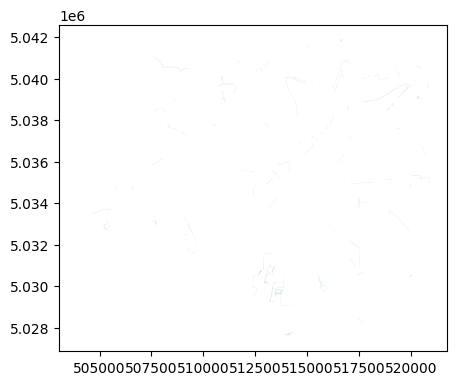

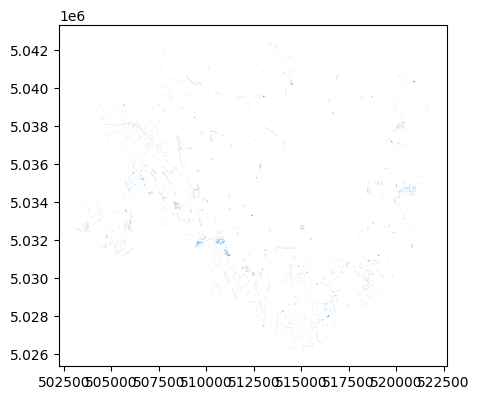

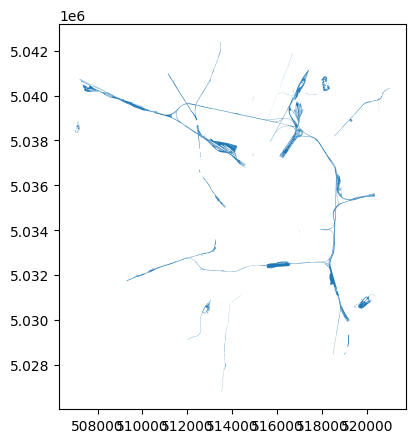

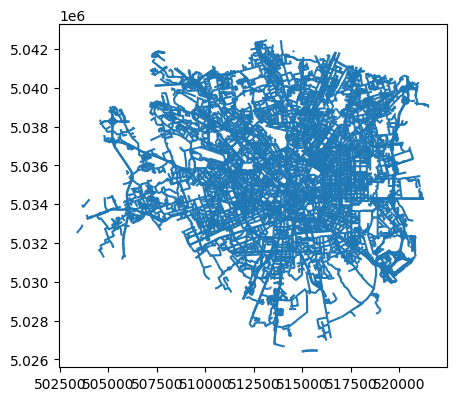

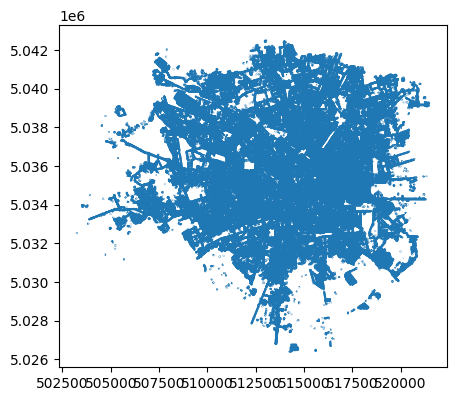

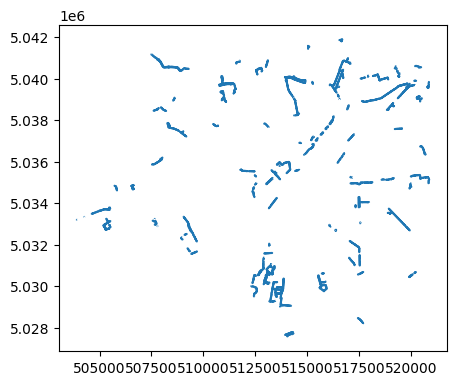

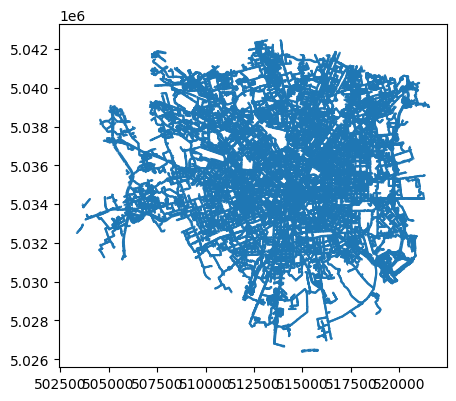

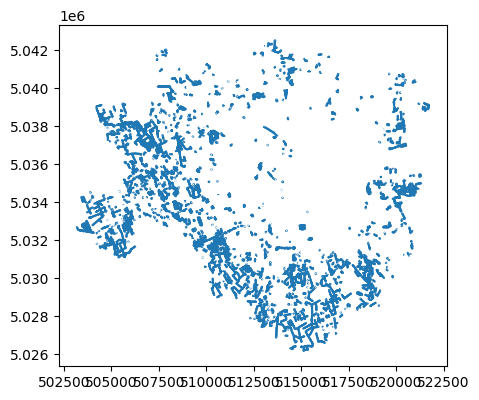

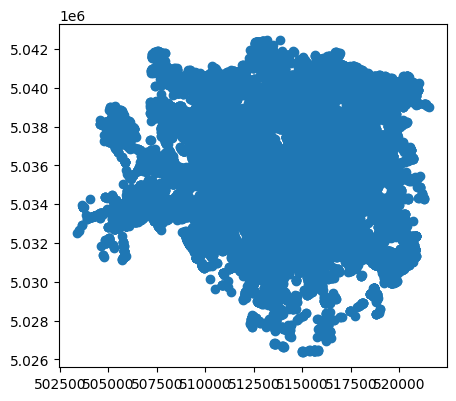

In [ ]:
if plottting:
  list(map(plot_dt, get_geofeather_Files("Viabilità")))

## Milano DBT

[========================================================================] 100%
[                                                                        ]   0%


Time occurred for plotting = 170.685139s


[========================================================================] 100%



Time occurred for plotting = 0.309781s


[<Axes: >, <Axes: >]

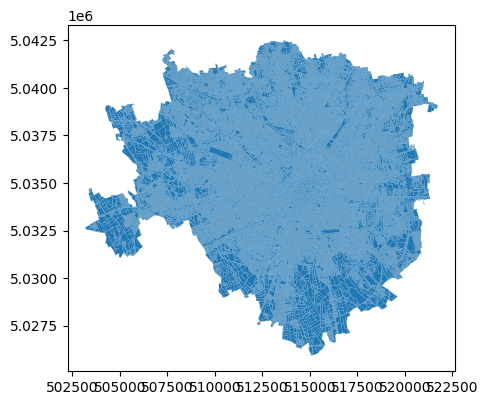

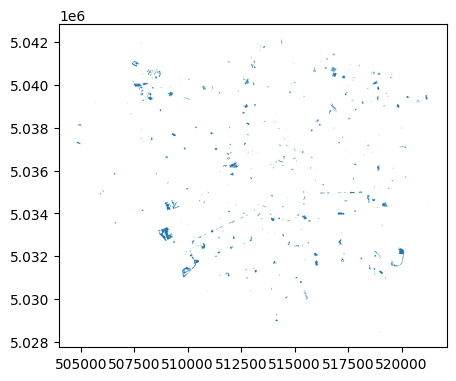

In [ ]:
if plottting:
  list(map(plot_dt, get_geofeather_Files("MILANO")))

#DBT Milan (Shape of different elements, for official Milan Urban Planning)

In [ ]:
milano_shape_dbt = get_geofeather_Files("MILANO")[0]
milano_shape_dbt

,codice_classe,dataset,attributo,codice,descrizione,destinazione_indicativa,superficie_mq,geometry
0,020206_AATT,AATT,AATT_TY,06,spazio interno generico,area attrezzata,43,"MULTIPOLYGON (((521271.530 5034359.160, 521270..."
1,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,3481,"MULTIPOLYGON (((520289.887 5036798.252, 520296..."
2,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,46,"MULTIPOLYGON (((520332.696 5035526.636, 520318..."
3,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,204,"MULTIPOLYGON (((520700.021 5039078.534, 520704..."
4,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,516,"MULTIPOLYGON (((520774.251 5039120.559, 520773..."
...,...,...,...,...,...,...,...,...
470227,020207_TRALIC,TRALIC_TRAL_BAS,TRAL_IMP,06,di linea elettrica,tecnologico - traliccio,12,"MULTIPOLYGON (((518293.497 5028627.085, 518293..."
470228,020207_TRALIC,TRALIC_TRAL_BAS,TRAL_IMP,06,di linea elettrica,tecnologico - traliccio,13,"MULTIPOLYGON (((518378.652 5028560.687, 518379..."
470229,020207_TRALIC,TRALIC_TRAL_BAS,TRAL_IMP,06,di linea elettrica,tecnologico - traliccio,10,"MULTIPOLYGON (((518413.776 5028564.718, 518414..."
470230,020207_TRALIC,TRALIC_TRAL_BAS,TRAL_IMP,06,di linea elettrica,tecnologico - traliccio,14,"MULTIPOLYGON (((517682.756 5028636.516, 517682..."


In [ ]:
if plottting:
  milano_shape_dbt.plot()

In [ ]:
milano_shape_dbt.descrizione.unique()

array(['spazio interno generico', 'cortile', 'altro', 'corte',
       'resede, spazio esterno generico', 'cavedio',
       'area antropizzata non ulteriormente qualificata',
       'vialetto di accesso', 'area di inumazione', 'chiostro', 'aia',
       'in sede normale', 'ciclabile', 'passaggio pedonale',
       'su marciapiede', 'vialetto', 'su salvagente',
       'aree solo pedonali (sagrato, piazza)', 'percorsi a gradinate',
       'galleria pedonale', 'area a porticato',
       'tronco carreggiata - controviale',
       'area a traffico non strutturato - in area di pertinenza',
       'fascia di sosta laterale',
       'area a traffico non strutturato - parcheggio',
       'tronco carreggiata - tronco ordinario',
       'area a traffico strutturato - rotatoria',
       'area a traffico strutturato - incrocio', 'tronco carreggiata',
       'tronco carreggiata - rampa/svincolo',
       'area a traffico strutturato', 'piazzola di sosta',
       'area a traffico non strutturato',
      

In [ ]:
milano_shape_dbt.dataset.unique()

array(['AATT', 'AB_CDA_AB_CDA_SUP_SR', 'AC_CIC_AC_CIC_SUP_SR',
       'AC_PED_AC_PED_SUP_SR', 'AC_VEI_AC_VEI_SUP_SR', 'ARGINE_ARGN_SUP',
       'AR_VMS_AR_VMS_SUP_SR', 'AR_VRD_AR_VRD_SUP', 'ATTR_SP', 'A_TRAS',
       'BOSCO', 'CL_AGR_CL_AGR_SUP', 'EDIFC_CR_EDF_IS',
       'EDI_MIN_CR_EDF_IS', 'FOR_PC_FOR_PC_SUP_SR', 'F_NTER_F_NTER_SU',
       'INVASO', 'MAN_TR_MAN_TR_SUP', 'MN_IND_MN_IND_SUP',
       'MN_MAU_MN_MAU_SUP', 'MU_DIV_MU_DIV_SUP', 'MU_SOS_MSOS_SUP',
       'OP_POR_OPPR_SUP', 'OP_REG_OP_REG_SUP_SR', 'PONTE_PONTE_SEDE',
       'PS_INC', 'SC_DIS', 'SD_FER_SD_FER_SUP_SR', 'SP_ACQ',
       'TRALIC_TRAL_BAS'], dtype=object)

In [ ]:
milano_shape_dbt = milano_shape_dbt.astype({'codice_strato_tema':'int'})
classi_attributi_ok = ["AATT", "AC_CIC", "ARGINE", "AR_VRD", "A_TRAS", "CL_AGR" "EDIFC", "INVASO", "MU_DIV", "PS_INC", "SP_ACQ"]
df_leggero = milano_shape_dbt[milano_shape_dbt["classe"].isin(classi_attributi_ok)]
df_leggero

,codice_classe,dataset,attributo,codice,descrizione,destinazione_indicativa,superficie_mq,geometry,codice_strato_tema,classe
0,020206_AATT,AATT,AATT_TY,06,spazio interno generico,area attrezzata,43,"MULTIPOLYGON (((521271.530 5034359.160, 521270...",20206,AATT
1,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,3481,"MULTIPOLYGON (((520289.887 5036798.252, 520296...",20206,AATT
2,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,46,"MULTIPOLYGON (((520332.696 5035526.636, 520318...",20206,AATT
3,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,204,"MULTIPOLYGON (((520700.021 5039078.534, 520704...",20206,AATT
4,020206_AATT,AATT,AATT_TY,01,cortile,area attrezzata,516,"MULTIPOLYGON (((520774.251 5039120.559, 520773...",20206,AATT
...,...,...,...,...,...,...,...,...,...,...
469600,040102_SP_ACQ,SP_ACQ,SP_ACQ_TY,02,stagno,acque,198,"MULTIPOLYGON (((514266.091 5028332.396, 514267...",40102,SP_ACQ
469601,040102_SP_ACQ,SP_ACQ,SP_ACQ_TY,01,lago,acque,37150,"MULTIPOLYGON (((516742.128 5029061.979, 516741...",40102,SP_ACQ
469602,040102_SP_ACQ,SP_ACQ,SP_ACQ_TY,01,lago,acque,16858,"MULTIPOLYGON (((516285.851 5029193.471, 516282...",40102,SP_ACQ
469603,040102_SP_ACQ,SP_ACQ,SP_ACQ_TY,01,lago,acque,29779,"MULTIPOLYGON (((516342.658 5027307.957, 516341...",40102,SP_ACQ


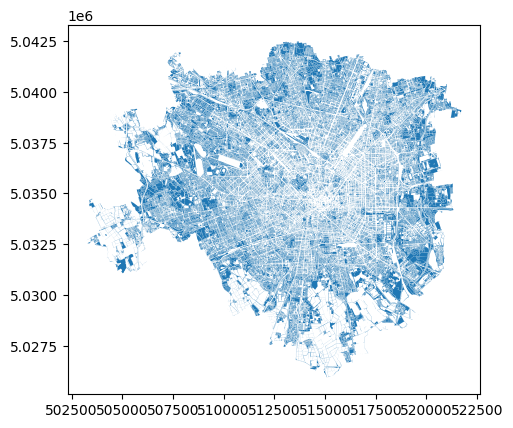

In [ ]:
df_leggero.plot()